Data Science for the Geosciences, 2022
       
Author: Lijing Wang (lijing52@stanford.edu)

---


In this notebook, we will perform outlier detection and removal on the central valley dataset.


**Expected learning outcomes**:   
*   Learn how to use Robust mahalanobis distance (Robust MD) to do outlier detection. 
*   Learn how to use machine learning methods: one-class SVM and isolation forest to do outlier detection. 

In [1]:
# load the necessary module
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.covariance import EmpiricalCovariance
from sklearn.covariance import MinCovDet
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [2]:
# Clone data from our GitHub repository
! git clone https://github.com/lijingwang/DataScienceForGeosciences.git

Cloning into 'DataScienceForGeosciences'...
remote: Enumerating objects: 369, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 369 (delta 83), reused 116 (delta 48), pack-reused 203
Receiving objects: 100% (369/369), 48.63 MiB | 21.13 MiB/s, done.
Resolving deltas: 100% (169/169), done.


In [3]:
## load compositional data analysis package
! pip install scikit-bio
from skbio.stats.composition import *

# Load geochem dataset, groundwater chemistry in Central Valley
data = pd.read_csv('/content/DataScienceForGeosciences/Ch2_StatsGeochem/Datapoints-CentralValley-Groundwater-Jan2019.csv')
## compositional data from geochemical dataset
compositional_data = np.array(data.values[:,6:-1],dtype = 'float64')
columns_name = data.columns[6:-1]

     |████████████████████████████████| 8.4 MB 4.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-bio: filename=scikit_bio-0.5.6-cp37-cp37m-linux_x86_64.whl size=1456861 sha256=9aeadd297cfa3a97859cb4556414bf32aee1521dcea11ff80fbe72ae9cb8f74c
  Stored in directory: /root/.cache/pip/wheels/7e/fa/86/a8b3b3b1187f0b0997fca40cdb7dd0d81a57ff061010e4464d
  Created wheel for hdmedians: filename=hdmedians-0.14.2-cp37-cp37m-linux_x86_64.whl size=454532 sha256=cacef9661a61940c0c0e9f0d9117ea2a21eaa97b637020f91fefa7ebf24d5951
  Stored in directory: /root/.cache/pip/wheels/56/5d/28/fb40426fbf6a8c3af88376a227130bbdf81e00177123e1398e
Successfully built scikit-bio hdmedians


# Robust multi-variate outlier detection

We first perform the centered log-ratio (clr) transformation on the compositional central valley dataset. 

In [4]:
clr_data = clr(compositional_data)
clr_data = pd.DataFrame(clr_data, columns = ['clr('+str(name) + ')' for name in columns_name])

We are interested in the chromium (Cr) contamination. Let's detect anomalies on the Chromium contamination first. 

## Plot 1: QQ plot, scatter plot, biplot



### Univariate: quantile-quantile plot

Text(0.5, 1.0, 'Histogram of clr(Cr)')

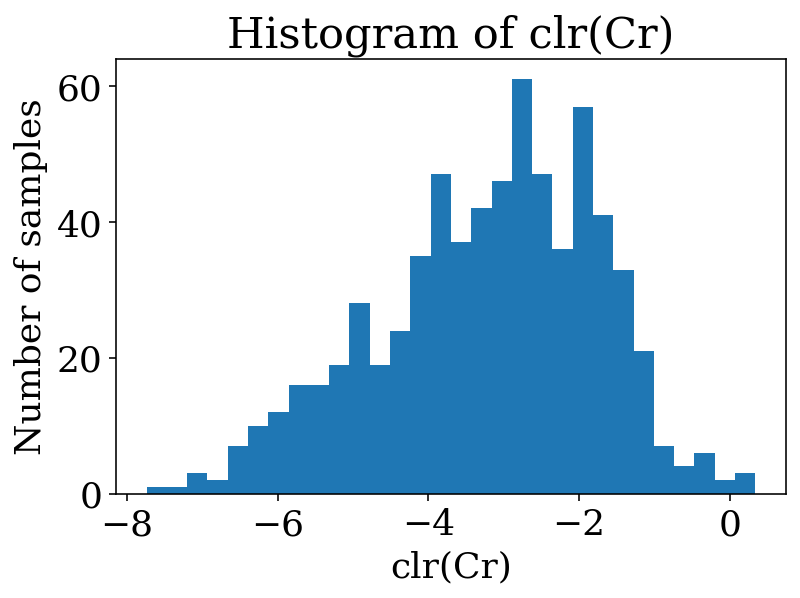

In [5]:
matplotlib.rcParams.update({'font.size': 18})
plt.hist(clr_data['clr(Cr (ppb))'],bins = 30)
plt.xlabel('clr(Cr)')
plt.ylabel('Number of samples')
plt.title('Histogram of clr(Cr)')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'Nomral quantile plot')

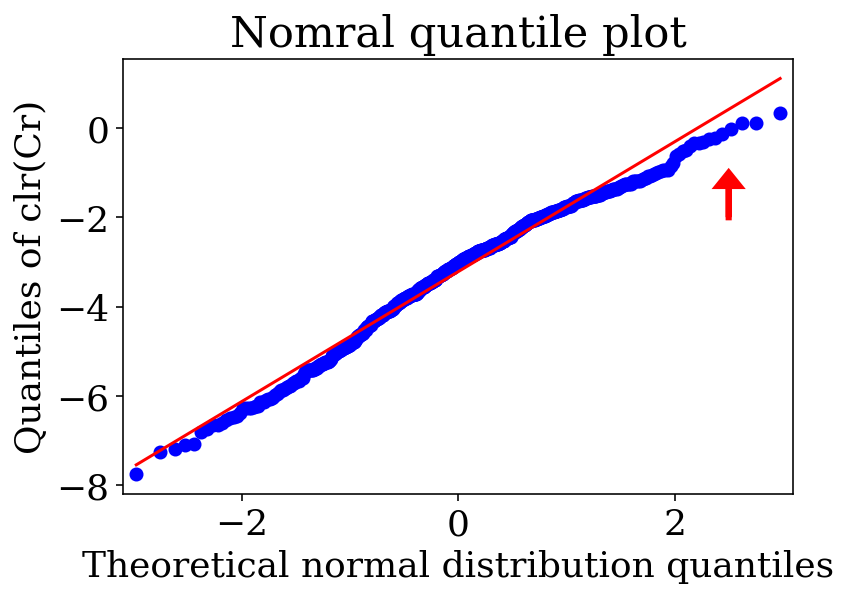

In [6]:
from statsmodels.graphics.gofplots import qqplot
fig = qqplot(clr_data['clr(Cr (ppb))'], line= 's')
plt.xlabel('Theoretical normal distribution quantiles')
plt.ylabel('Quantiles of clr(Cr)')
plt.arrow(2.5, -2, 0, 1, length_includes_head=True, color='r',
          linewidth=3, head_width=0.2, head_length=0.3)
plt.title('Nomral quantile plot')

Here we compare the clr(Cr) distribution with the normal distribution. It shows that larger values of clr(Cr) are deviated from the normal distribution, which means those samples are outliers if we assume our dataset is normal distributed. 

### Bivariate: scatter plot, Cr and As

Text(0.5, 1.0, 'Scatter plot')

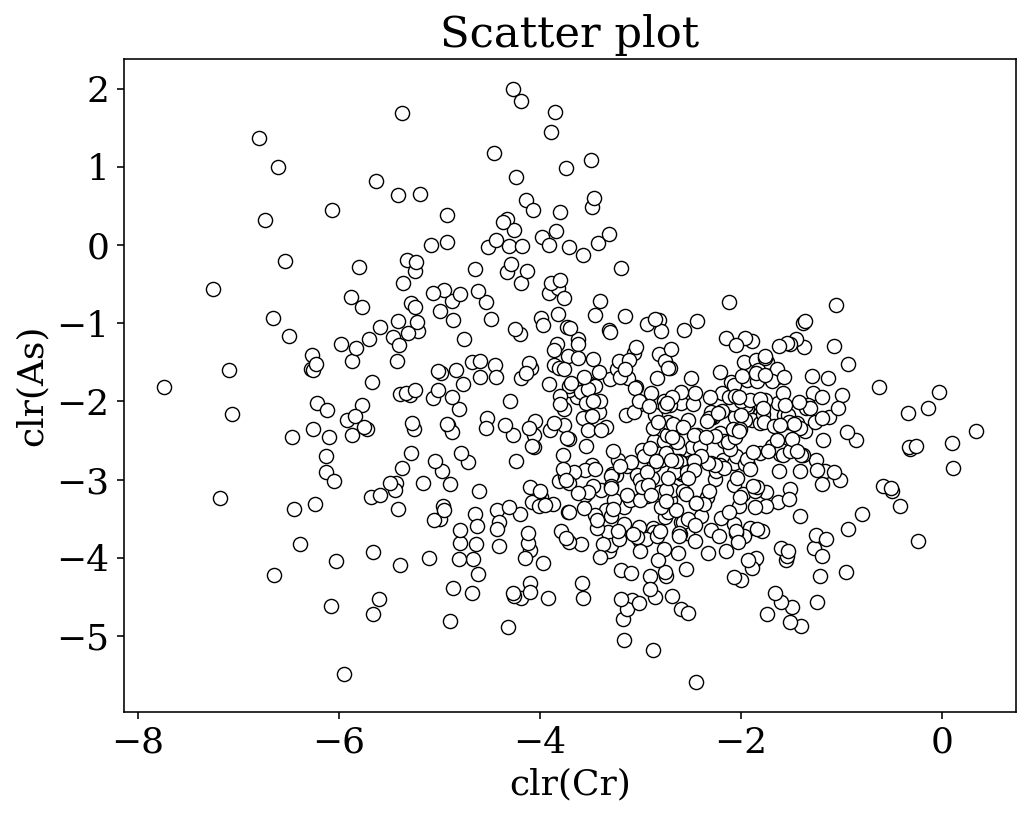

In [7]:
plt.figure(figsize=[8,6])
plt.scatter(clr_data['clr(Cr (ppb))'],clr_data['clr(As (ppb))'], s=50, c='w', edgecolor='k', linewidths=0.7)
plt.xlabel('clr(Cr)')
plt.ylabel('clr(As)')
plt.title('Scatter plot')

### Biplot

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(-0.16, 0.16)

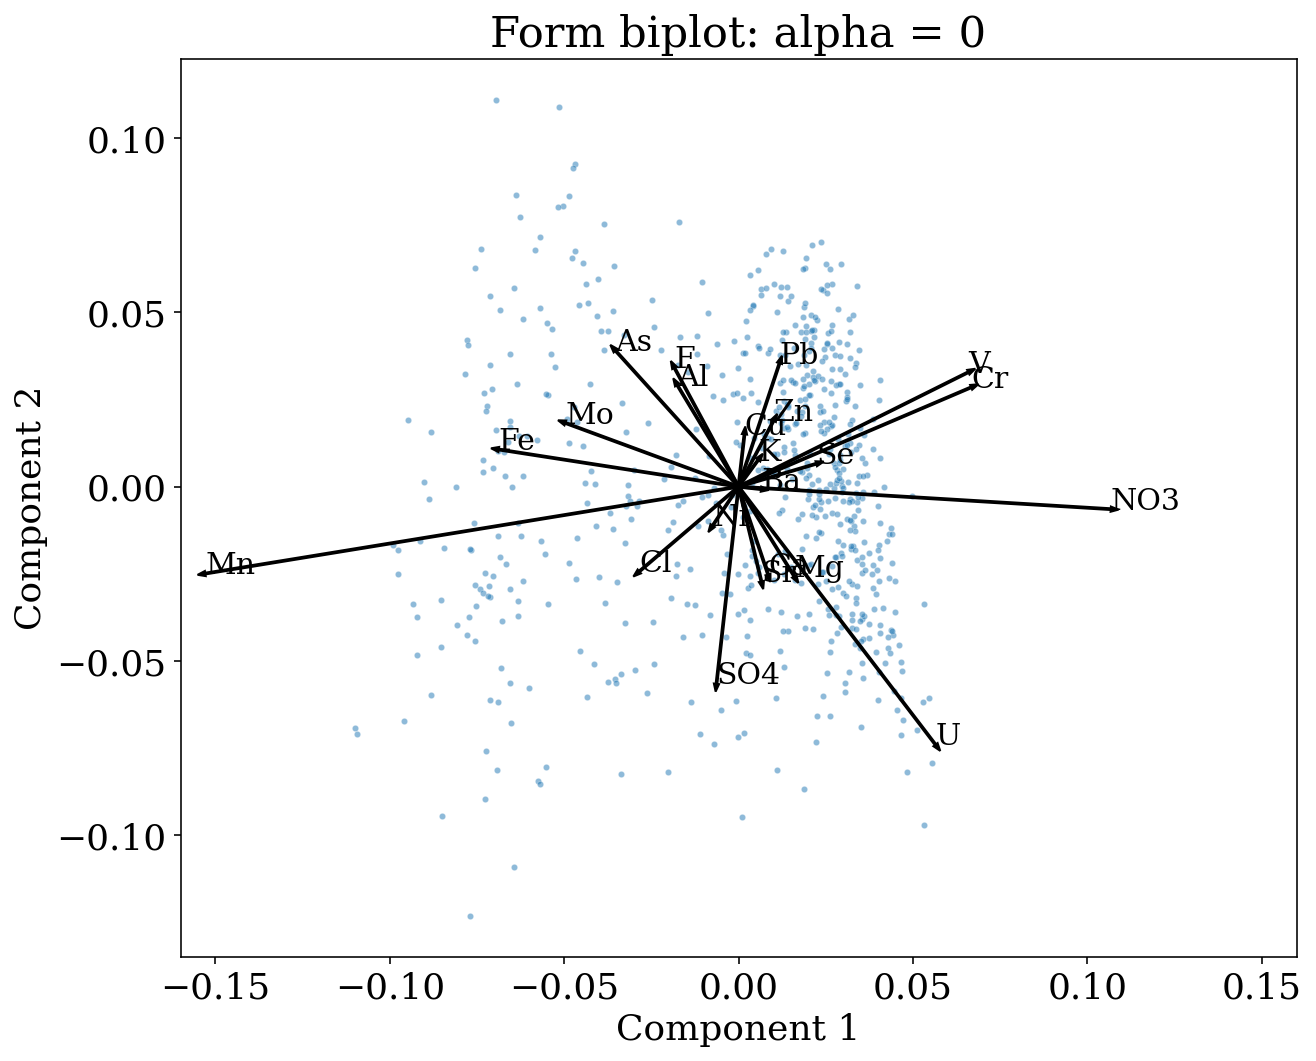

In [8]:
# biplot
def biplot_return_G_H(data,alpha = 0):
    u, s, v = np.linalg.svd(data)
    u = u[:,:len(s)]
    mat1 = np.diag(np.power(s,alpha))
    mat2 = np.diag(np.power(s,1-alpha))
    G = np.dot(u,mat1)
    H = np.dot(mat2,v)
    return G, H

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_std=False)
clr_data_centered = scaler.fit_transform(clr_data.values)

# alpha = 0, form biplot
alpha = 0
G, H = biplot_return_G_H(clr_data_centered,alpha = alpha)

D = 22
vis_scale = 1/400
comp_index = np.array([0,1]) # Plot component 1 and component 2. 

plt.figure(figsize=[10,10])
sns.scatterplot(G[:,comp_index[0]],G[:,comp_index[1]],alpha = 0.5,s = 10)
for i in range(D):
    plt.arrow(0, 0, H[comp_index[0],i]*vis_scale,
              H[comp_index[1],i]*vis_scale, width = 5e-4,
              color='black',zorder = 2)
    plt.text(H[comp_index[0],i]*vis_scale, H[comp_index[1],i]*vis_scale, clr_data.columns[i].split('(')[1].split(' ')[0], size = 15, zorder = 20)
plt.gca().set(aspect='equal')
plt.title('Form biplot: alpha = '+str(alpha))
plt.xlabel('Component '+str(comp_index[0]+1))
plt.ylabel('Component '+str(comp_index[1]+1))
plt.xlim(-0.16,0.16)

## Plot 2: Determinant function of outliers removed

### Determinant function

In [9]:
## Bivariate data: clr(Cr), clr(As)
X = clr_data[['clr(Cr (ppb))','clr(As (ppb))']].values
name1, name2 = ['clr(Cr)','clr(As)']

In [10]:
## robust MD
rob_cov = MinCovDet().fit(X)
RMD = np.sqrt(rob_cov.mahalanobis(X))

/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_empirical_covariance.py:87: UserWarning: Only one sample available. You may want to reshape your data array
  "Only one sample available. You may want to reshape your data array"


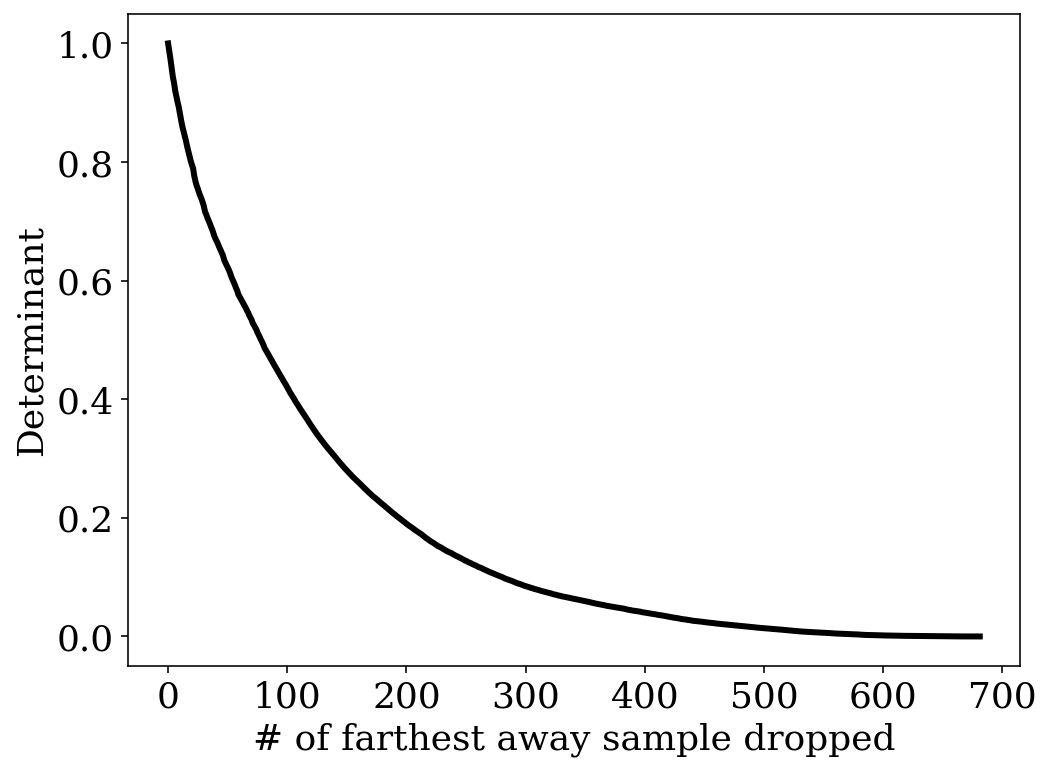

In [11]:
## Determinant function 
cov_dets = []
RMD_sorted = np.sort(RMD)[::-1]

for outlier_id in range(len(X)-1):
  new_X = X[RMD<RMD_sorted[outlier_id]]
  new_cov = EmpiricalCovariance().fit(new_X).covariance_
  cov_dets.append(np.linalg.det(new_cov))
plt.figure(figsize=[8,6])
plt.plot(cov_dets/np.max(cov_dets), color = 'k',linewidth = 3)
np.linalg.det(new_cov)
plt.xlabel('# of farthest away sample dropped')
plt.ylabel('Determinant')
plt.show()

### Compare MD and robust RMD

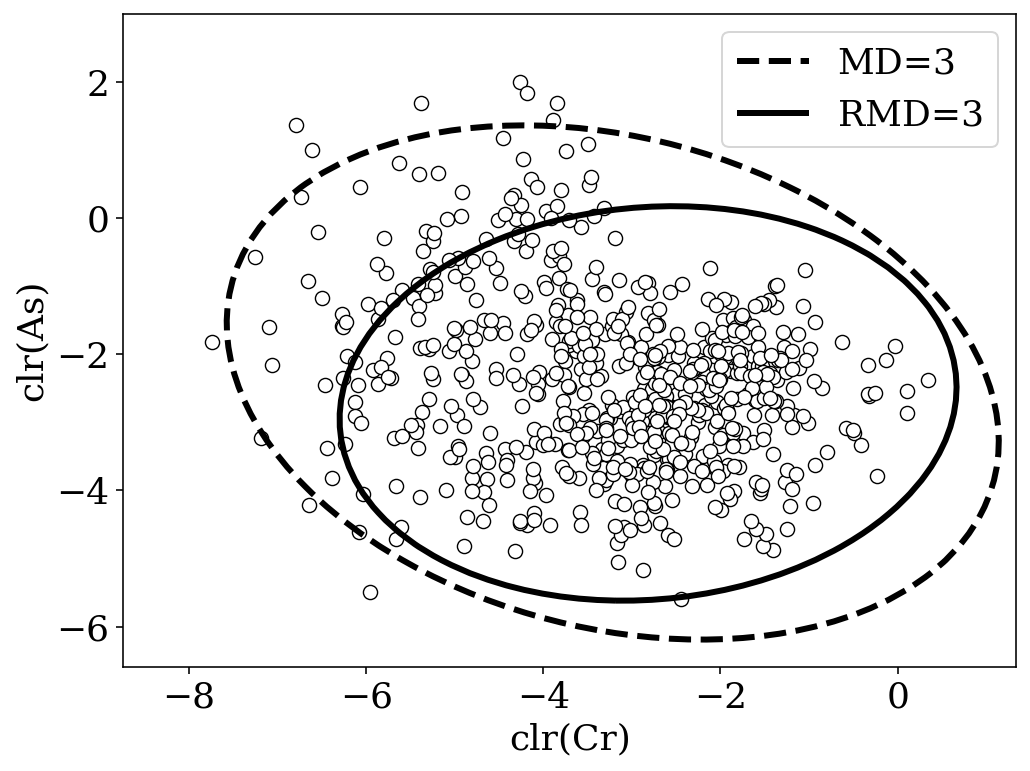

In [12]:
## X data: clr(Cr), clr(As)
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0])-1,np.max(X[:,0])+1),
                     np.linspace(np.min(X[:,1])-1,np.max(X[:,1])+1))
## empirical MD
emp_cov = EmpiricalCovariance().fit(X)
MD = np.sqrt(emp_cov.mahalanobis(X))
MD_contour = emp_cov.mahalanobis(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

## robust MD
rob_cov = MinCovDet().fit(X)
RMD = np.sqrt(rob_cov.mahalanobis(X))
RMD_contour = rob_cov.mahalanobis(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=[8,6])
plt.scatter(X[:,0], X[:,1],  s=50, c='w', edgecolor='k', linewidths=0.7)
a = plt.contour(xx, yy, np.sqrt(MD_contour), levels=[3], colors='k', linestyles = 'dashed', linewidths=3)
a.collections[0].set_label('MD=3')
b = plt.contour(xx, yy, np.sqrt(RMD_contour), levels=[3], colors='k',linewidths=3)
b.collections[0].set_label('RMD=3')
plt.legend(loc='upper right')

plt.xlabel(name1)
plt.ylabel(name2)
plt.show()

## Plot 3: Chi-square quantile plot of the robust MD



We compare robust MD and Chi-square distribution.

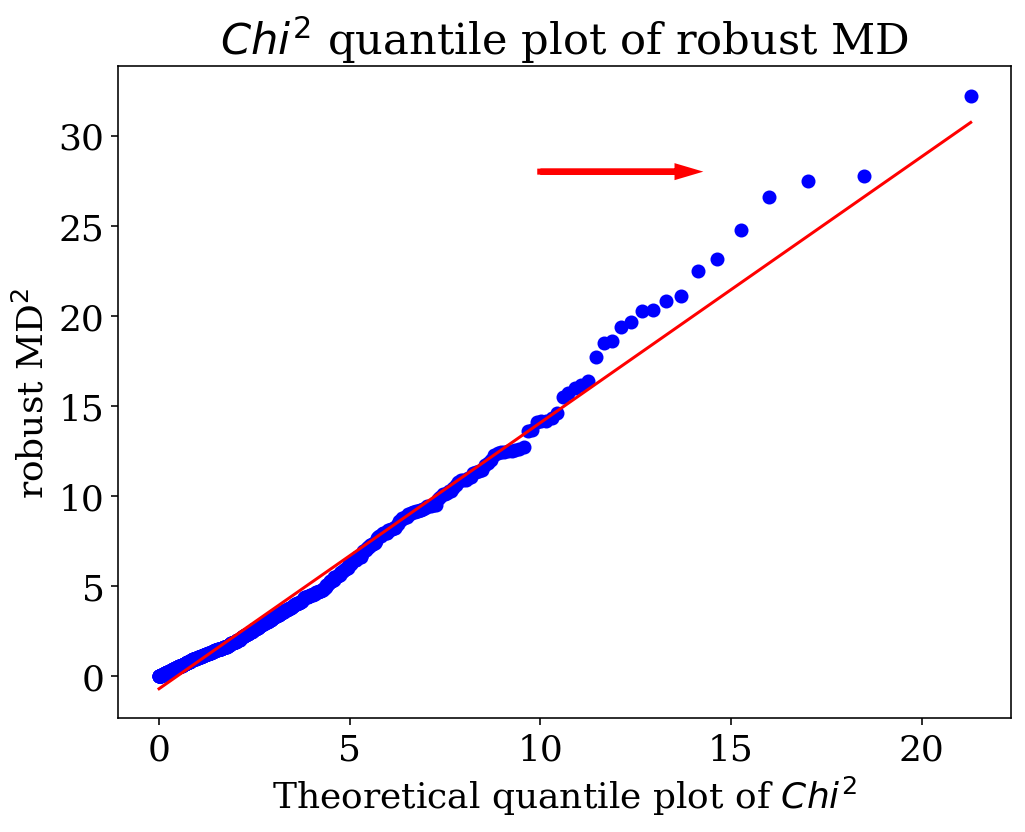

In [13]:
chi2_param = stats.chi2.fit(np.square(RMD))
plt.figure(figsize=[8,6])
stats.probplot(np.square(RMD), dist = stats.chi2, sparams = chi2_param, fit = True, plot=plt)
plt.title('$Chi^2$ quantile plot of robust MD')
plt.xlabel('Theoretical quantile plot of $Chi^2$')
plt.ylabel('robust MD$^2$')
plt.arrow(10, 28, 4, 0, length_includes_head=True, color='r',
          linewidth=3, head_width=0.5, head_length=0.4)
plt.show()

Samples deviating from the straight line of chi-square quantile plot: RMD > 15. 

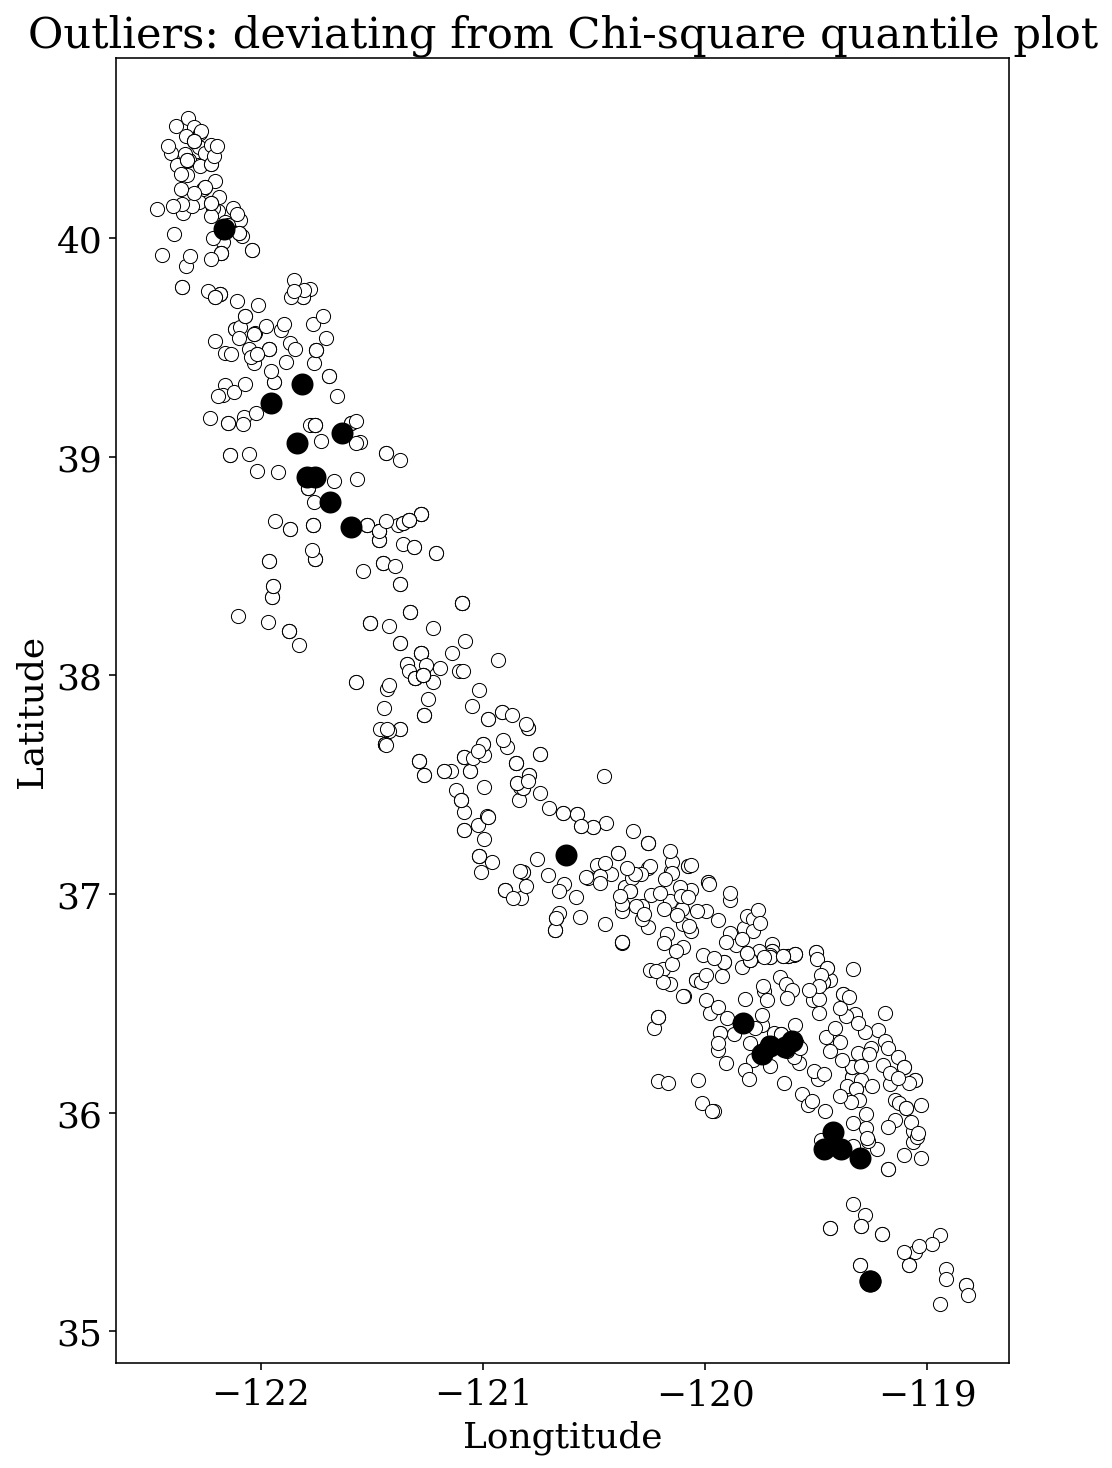

In [25]:
plt.figure(figsize=(8,12))
plt.scatter(data['Longitude'],data['Latitude'], c = 'w', edgecolors='k', linewidths=0.5, s=50)
plt.scatter(data['Longitude'][np.square(RMD)>15],
            data['Latitude'][np.square(RMD)>15],             
            c = 'k',s=100)
plt.xlabel('Longtitude')
plt.ylabel('Latitude')
plt.title('Outliers: deviating from Chi-square quantile plot')
plt.show()

## Plot 4: Scatter plot indicating the robust MD


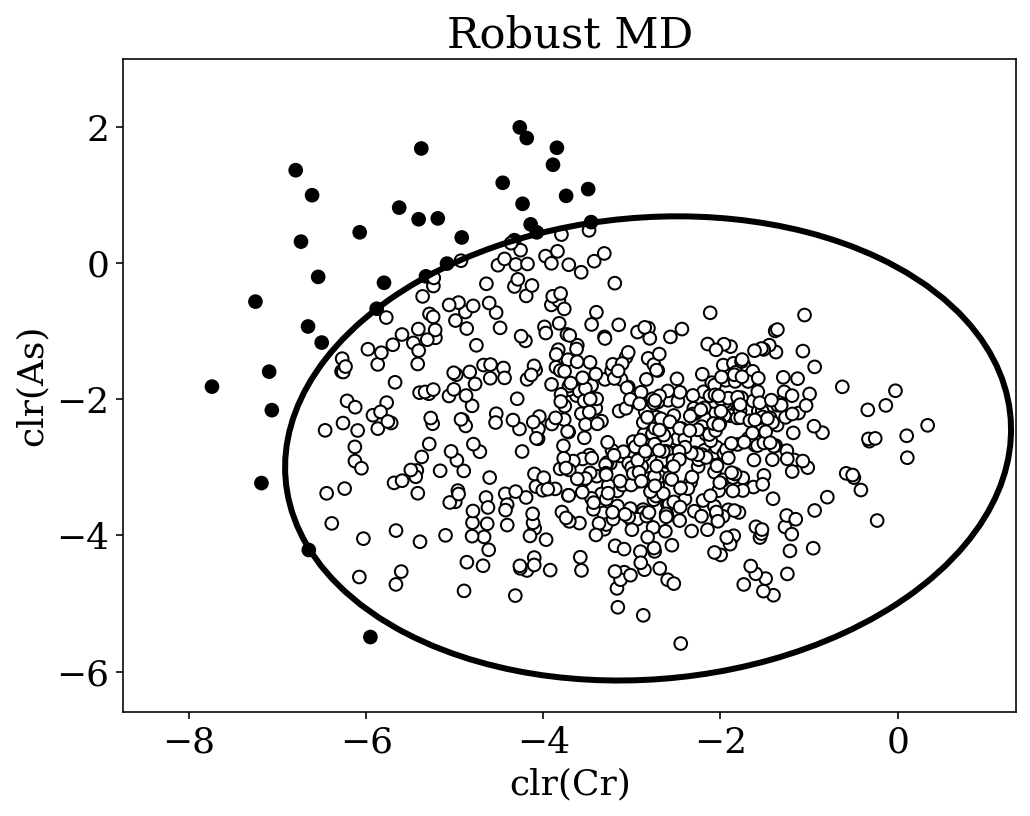

In [14]:
boundary = np.quantile(np.square(RMD),0.95)
outlier_index = (np.square(RMD)>= boundary)

plt.figure(figsize=[8,6])
plt.scatter(X[:,0], X[:,1], c=outlier_index,s = 40,edgecolors = 'k',cmap ='Greys')

a = plt.contour(xx, yy, np.sqrt(RMD_contour), levels=[np.sqrt(boundary)], colors='k',linewidths=3)

plt.xlabel(name1)
plt.ylabel(name2)
plt.title('Robust MD')
plt.show()

## Plot 5: Outliers marked on maps

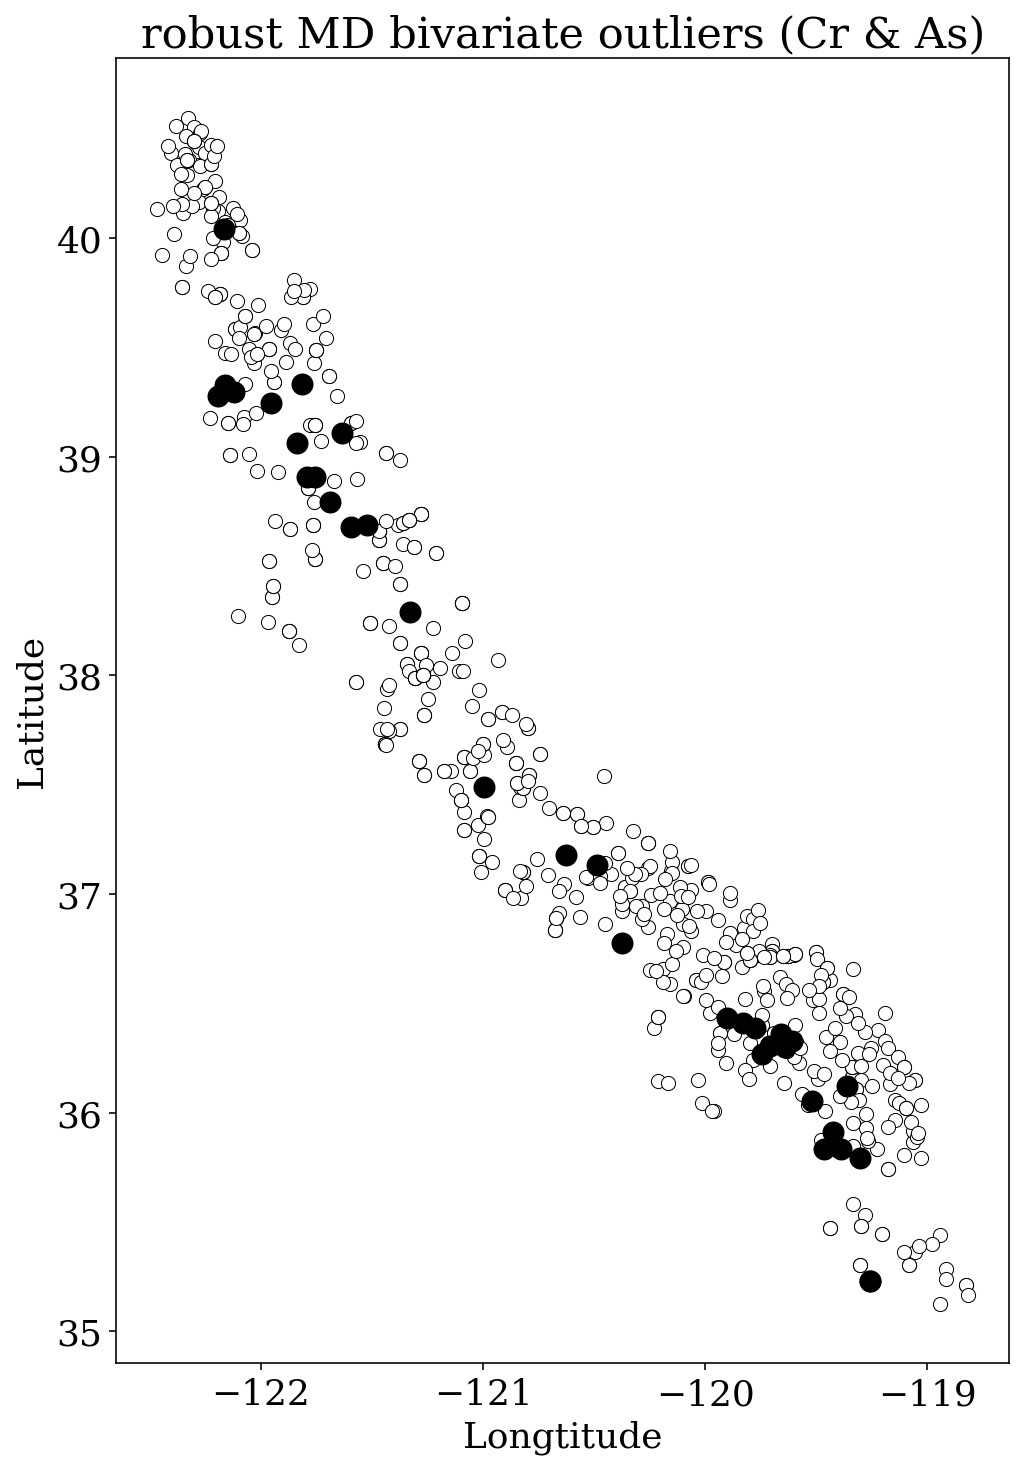

In [15]:
plt.figure(figsize=(8,12))
plt.scatter(data['Longitude'],data['Latitude'], c = 'w', edgecolors='k', linewidths=0.5, s=50)
plt.scatter(data['Longitude'][outlier_index],
            data['Latitude'][outlier_index],             
            c = 'k',s=100)
plt.xlabel('Longtitude')
plt.ylabel('Latitude')
plt.title('robust MD bivariate outliers (Cr & As)')
plt.show()

# Bivariate outliers $\neq$ univariate outliers

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'label'
  


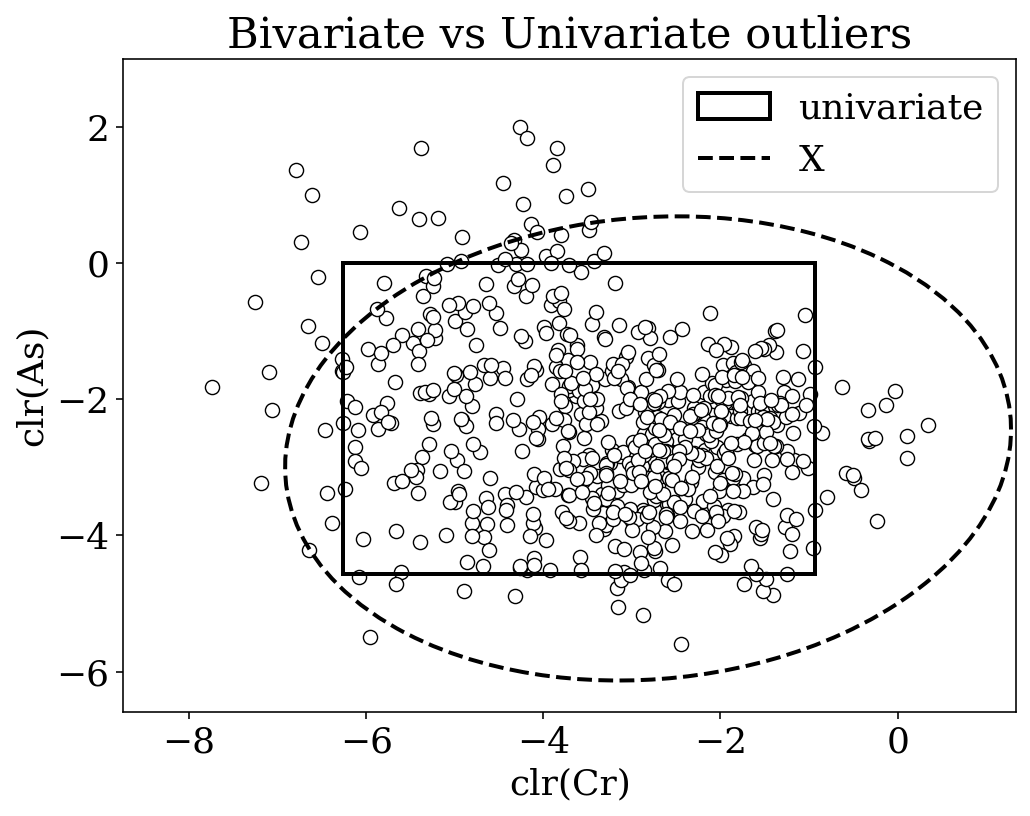

In [16]:
import matplotlib.patches as patches

fig,ax = plt.subplots(figsize=(8,6))

# Draw the ellipse boundary
ax.scatter(X[:, 0], X[:, 1], s=50, c='w', edgecolor='k', linewidths=0.7)
a = plt.contour(xx, yy, np.sqrt(RMD_contour), levels=[np.sqrt(boundary)], 
                colors='black', linewidths = 2, linestyles='--',label = 'X')
a.collections[0].set_label('X')
# Create a Rectanglar based on 2.5nd and 97.5th quantile of each variable. 
cr_lower, cr_upper = np.quantile(X[:, 0],0.025), np.quantile(X[:, 0],0.975)
as_lower, as_upper = np.quantile(X[:, 1],0.025), np.quantile(X[:, ],0.975)

rect = patches.Rectangle((cr_lower, as_lower), cr_upper-cr_lower, as_upper - as_lower, 
                         linewidth=2, edgecolor='k',facecolor='none',label = 'univariate')
ax.add_patch(rect)
plt.xlabel(name1)
plt.ylabel(name2)
plt.title('Bivariate vs Univariate outliers')
plt.legend()
plt.show()

# Outlier detection using machine learning

## One-class SVM


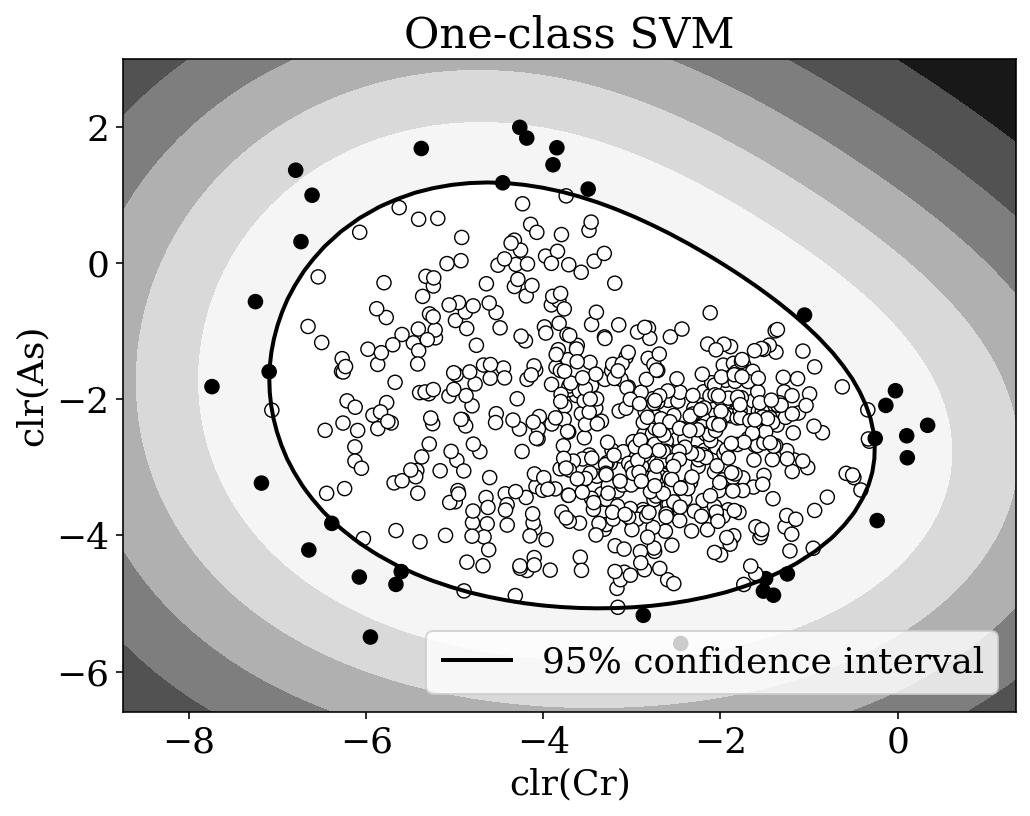

In [17]:
outlier_proportion = 0.05
clf = svm.OneClassSVM(nu=outlier_proportion, kernel='rbf',gamma=0.05)
clf.fit(X)
y_pred_SVM = clf.predict(X)
scores_pred = clf.decision_function(X)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

frontier = stats.scoreatpercentile(scores_pred, outlier_proportion*100)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7),cmap="Greys_r")
a = plt.contour(xx, yy, Z, levels=[frontier], linewidths=2, colors='k')
plt.scatter(X[:, 0], X[:, 1], c=y_pred_SVM, cmap='binary_r', s=50, edgecolor='k',linewidths=0.7)
plt.legend([a.collections[0]], ['95% confidence interval'], loc='lower right')
plt.xlabel(name1)
plt.ylabel(name2)
plt.title('One-class SVM')
plt.show()

## Isolation forest

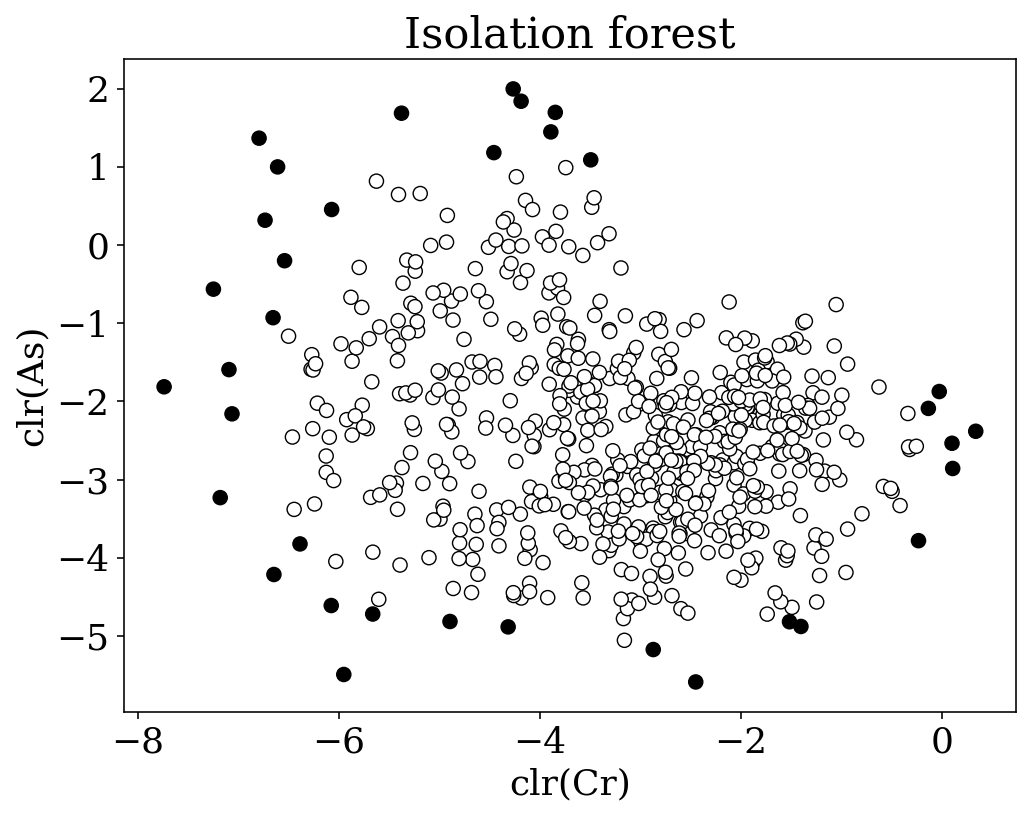

In [18]:
# determine outlier proportions
outlier_proportion = 0.05
# fit to isolation forest
clf = IsolationForest(contamination=outlier_proportion, random_state=9)
clf.fit(X)
y_pred_forest = clf.predict(X)
scores_pred = clf.decision_function(X)

frontier = stats.scoreatpercentile(scores_pred, outlier_proportion*100)
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=y_pred_forest, cmap='binary_r', s=50, edgecolor='k',linewidths=0.7)
plt.xlabel(name1)
plt.ylabel(name2)
plt.title('Isolation forest')
plt.show()

## Outliers marked on maps

Text(0.5, 1.0, 'Isolation forest')

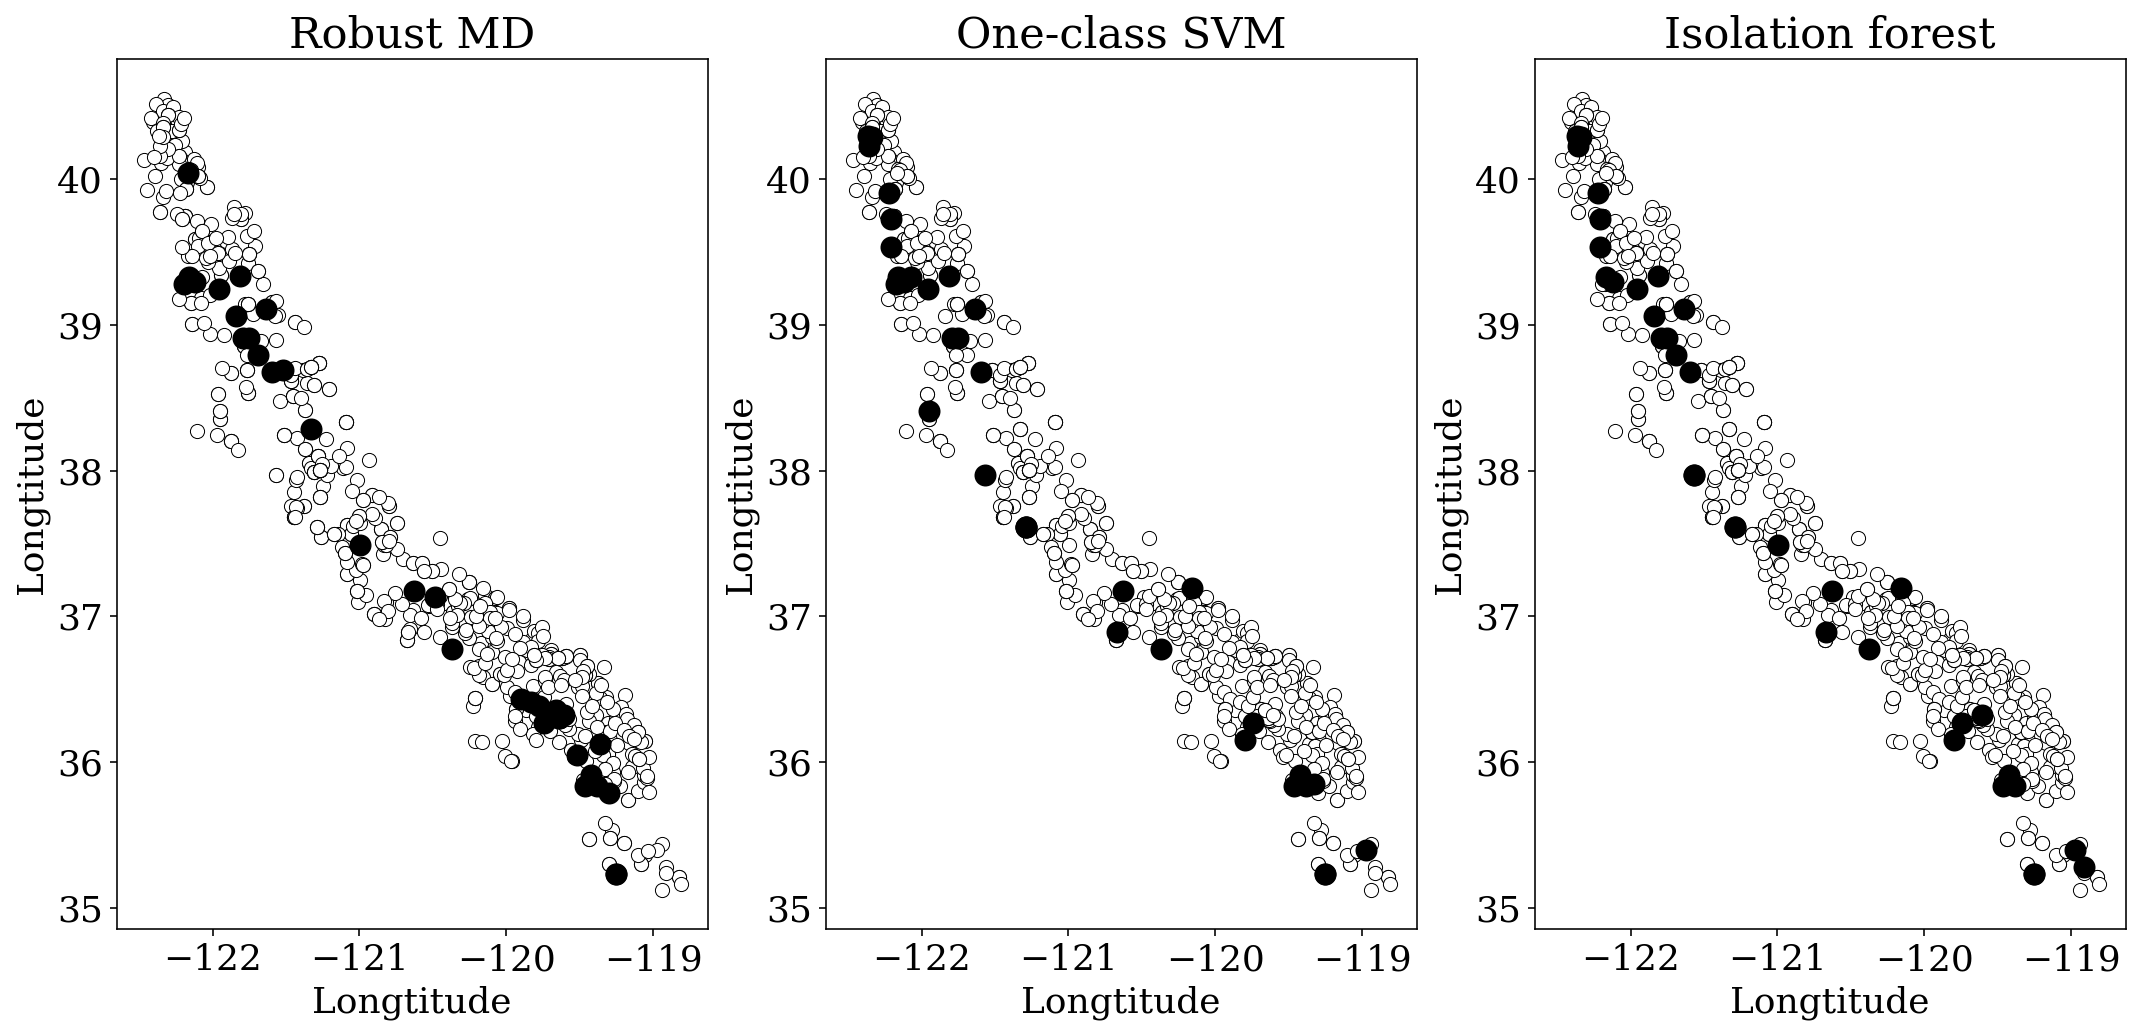

In [19]:

matplotlib.rcParams.update({'font.size': 18})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,8))

plot1 = ax1.scatter(data['Longitude'],data['Latitude'], c = 'w', edgecolors='k', linewidths=0.5, s=50)
ax1.scatter(data['Longitude'][outlier_index],
            data['Latitude'][outlier_index],             
            c = 'k',s=100)
ax1.set_xlabel('Longtitude')
ax1.set_ylabel('Longtitude')
ax1.set_title('Robust MD')


plot2 = ax2.scatter(data['Longitude'],data['Latitude'], c = 'w', edgecolors='k', linewidths=0.5, s=50)
ax2.scatter(data['Longitude'][y_pred_SVM == -1],
            data['Latitude'][y_pred_SVM == -1],             
            c = 'k',s=100)
ax2.set_xlabel('Longtitude')
ax2.set_ylabel('Longtitude')
ax2.set_title('One-class SVM')

plot3 = ax3.scatter(data['Longitude'],data['Latitude'], c = 'w', edgecolors='k', linewidths=0.5, s=50)
ax3.scatter(data['Longitude'][y_pred_forest == -1],
            data['Latitude'][y_pred_forest == -1],             
            c = 'k',s=100)
ax3.set_xlabel('Longtitude')
ax3.set_ylabel('Longtitude')
ax3.set_title('Isolation forest')
